In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed) 

In [4]:
DATASET_PATH = r'C:\Users\Dell\Desktop\Triggerword-Detection-Project\trigger-techolution-be\door_open_door_close_door_stop_max_1sec\hackathon'

data_dir = pathlib.Path(DATASET_PATH)


In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)


Commands: ['door_close' 'door_open' 'door_stop']


In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 12674 files belonging to 3 classes.
Using 10140 files for training.
Using 2534 files for validation.

label names: ['door_close' 'door_open' 'door_stop']


In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: door_close
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: door_stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: door_close
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [16]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)         

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [24]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


159/159 [==============================] - 17s 97ms/step - loss: 0.6632 - accuracy: 0.7315 - val_loss: 0.4224 - val_accuracy: 0.8604
Epoch 2/10
159/159 [==============================] - 16s 98ms/step - loss: 0.3586 - accuracy: 0.8750 - val_loss: 0.2761 - val_accuracy: 0.9179
Epoch 3/10
159/159 [==============================] - 15s 94ms/step - loss: 0.2367 - accuracy: 0.9211 - val_loss: 0.2324 - val_accuracy: 0.9338
Epoch 4/10
159/159 [==============================] - 15s 93ms/step - loss: 0.1912 - accuracy: 0.9353 - val_loss: 0.1868 - val_accuracy: 0.9426
Epoch 5/10
159/159 [==============================] - 14s 87ms/step - loss: 0.1511 - accuracy: 0.9515 - val_loss: 0.1727 - val_accuracy: 0.9458
Epoch 6/10
159/159 [==============================] - 14s 85ms/step - loss: 0.1295 - accuracy: 0.9540 - val_loss: 0.1553 - val_accuracy: 0.9514
Epoch 7/10
159/159 [==============================] - 14s 87ms/step - loss: 0.1104 - accuracy: 0.9639 - val_loss: 0.1519 - val_accurac

In [25]:
model.evaluate(test_spectrogram_ds, return_dict=True)

20/20 [==============================] - 2s 78ms/step - loss: 0.0943 - accuracy: 0.9711


{'loss': 0.09431099891662598, 'accuracy': 0.9710937738418579}

In [26]:
y_pred = model.predict(test_spectrogram_ds)

20/20 [==============================] - 1s 21ms/step


In [27]:
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

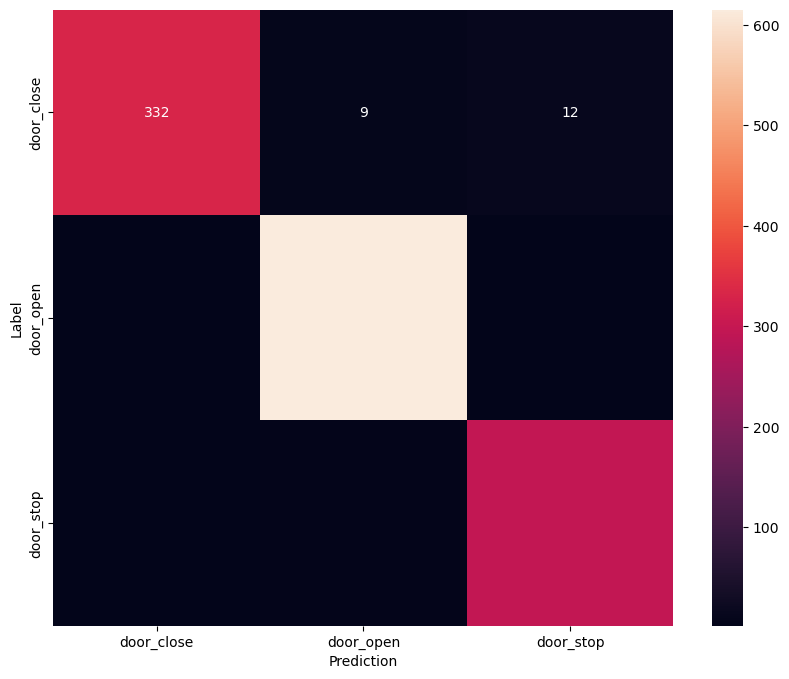

In [28]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [29]:
model.save("cnn")

INFO:tensorflow:Assets written to: cnn\assets


INFO:tensorflow:Assets written to: cnn\assets


In [30]:
model.save("cnn.h5")

C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
tf.saved_model.save(model,r'C:\Users\Dell\Desktop\Triggerword-Detection-Project\trigger-techolution-be\model')

INFO:tensorflow:Assets written to: C:\Users\Dell\Desktop\Triggerword-Detection-Project\trigger-techolution-be\model\assets


INFO:tensorflow:Assets written to: C:\Users\Dell\Desktop\Triggerword-Detection-Project\trigger-techolution-be\model\assets


In [34]:
imported = tf.saved_model.load(r'C:\Users\Dell\Desktop\Triggerword-Detection-Project\trigger-techolution-be\model')

In [35]:
imported

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x2d0ce138610>